In [2]:
from captcha.image import ImageCaptcha
from matplotlib import pyplot as plt
import glob
import numpy as np
import random
import os
import string
from PIL import Image 
import time
import tensorflow as tf
import pickle
%matplotlib inline


In [3]:
#image = ImageCaptcha(fonts=['./font/AntykwaBold.ttf', './font/Candice.ttf', './font/VeraMono.ttf', './font/verdana.ttf'])

# %%timeit
# X = []
# for i in range(1000):
#     text = ''.join(random.sample(char_map, 4))
#     img = np.array(image.generate_image(text).resize((100, 40)))
#     img_gray = np.mean(img, -1)
#     if not isinstance(X, np.ndarray):
#         X = img_gray[..., np.newaxis]
#     else:
#         X = np.concatenate((X, img_gray[..., np.newaxis]), axis=-1)
#     #灰度值求解
#     #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
#     if i % 100 == 0:
#         print("generating captcha " , i)

num_char = 4
num_images_train = 10000
num_images_test = 1000
width_images = 100
height_images = 40
num_charmap = 36
num_channel = 1
char_map = string.ascii_uppercase + string.digits



image_generator = ImageCaptcha(fonts=['./font/AntykwaBold.ttf'])

def dataset_generator(num_images):
    X = np.empty((num_images, height_images, width_images))
    y = np.empty((num_images, num_charmap*num_char))
    for i in range(num_images):
        text = ''.join(random.sample(char_map, num_char))
        img = np.array(image_generator.generate_image(text).resize((width_images, height_images)))
        img_gray = np.mean(img, -1)
        img_scale = np.multiply(img_gray, 1/255.0)
        X[i, :, :] = img_scale
        y_index = [ char_map.find(text[_i])+_i*num_charmap for _i in range(num_char)]
        y[i, y_index] = 1

        #灰度值求解
        #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
        if (i+1) % (num_images/5) == 0:
            print("generating captcha " , i)
    return X, y
     
def get_next_batch(X, y, batch_size=100):
    index_in_epoch = 0
    num_images = X.shape[0]
    while True:
        start = index_in_epoch
        index_in_epoch += batch_size
        if index_in_epoch > num_images:
            perm = np.arange(num_images)
            np.random.shuffle(perm)
            X = X[perm]
            y = y[perm]
            start = 0
            index_in_epoch = batch_size
            assert batch_size <= num_images
        end = index_in_epoch
        yield X[start:end], y[start:end]     

# print("generate train dataset: \n", '-'*40)
# X_train, y_train = dataset_generator(num_images_train)
# print("generate test dataset: \n", '-'*40)
# X_test, y_test = dataset_generator(num_images_test)
# y_test = np.reshape(y_test, [-1, num_char, num_charmap])   
 

dataset_dir = "./captcha_data/"
dataset_name = "captcha.pickle"
dataset_path = os.path.join(dataset_dir, dataset_name)
if os.path.exists(dataset_path):
    with open(dataset_path, 'rb') as f:
        X_train = pickle.load(f)
        y_train = pickle.load(f)
        y_test = pickle.load(f)
        X_test = pickle.load(f)
else:
    if not os.path.isdir(dataset_dir):
        os.mkdir(dataset_dir)
    print("generate train dataset: \n", '-'*40)
    X_train, y_train = dataset_generator(num_images_train)
    print("generate test dataset: \n", '-'*40)
    X_test, y_test = dataset_generator(num_images_test)
    y_test = np.reshape(y_test, [-1, num_char, num_charmap])
    with open(dataset_path, 'wb') as f:
        pickle.dump(X_train, f)
        pickle.dump(y_train, f)
        pickle.dump(y_test, f)
        pickle.dump(X_test, f)



In [4]:
# def weight_variable(shape):
#     initial = tf.truncated_normal(shape, stddev=0.1)
#     return tf.Variable(initial)

# def bias_variable(shape):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.Variable(initial)

# def conv2d(x, W):
#     return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# def max_pool_2x2(x):
#     return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# # with tf.device('/gpu:0'):
# x = tf.placeholder(tf.float32, [None, height_images, width_images])
# y_ = tf.placeholder(tf.float32, [None, num_char, num_charmap])

# #todo: find out why reshape doesn.t work
# x_image = tf.reshape(x, [-1, height_images, width_images, 1])
# # y_ = tf.reshape(y_, [-1, num_char, num_charmap])

# #Dropout
# keep_prob = tf.placeholder(tf.float32)


# #First Convolutional Layer
# W_conv1 = weight_variable([5, 5, 1, 32])
# b_conv1 = bias_variable([32])
# h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
# h_pool1 = max_pool_2x2(h_conv1)

# #Second Convolutional Layer
# W_conv2 = weight_variable([5, 5, 32, 64])
# b_conv2 = bias_variable([64])
# h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_pool2 = max_pool_2x2(h_conv2)

# #Third Convolutional Layer
# # W_conv3 = weight_variable([5, 5, 64, 128])
# # b_conv3 = bias_variable([128])
# # h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# # h_pool3 = max_pool_2x2(h_conv2)

# #First densely Connected Layer
# W_fc1 = weight_variable([10 * 25 * 64, 1024])
# b_fc1 = bias_variable([1024])
# h_pool2_flat = tf.reshape(h_pool2, [-1, 10*25*64])
# h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# #Readout Layer
# W_fc2 = weight_variable([1024, 144])
# b_fc2 = bias_variable([144])

# y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# #cross_entropy_1 无法导向正确结果，废弃
# #cross_entropy_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
# #分别计算每个char的softmax损失函数，取其平均值作为整体的损失函数


# y_conv = tf.reshape(y_conv, [-1, num_char, num_charmap])

# cross_entropy = tf.reduce_mean(tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(y_conv[:, _i ,:], y_[:, _i,:]) 
#                   for _i in range(num_char) ]))

# # cross_entropy = tf.reduce_mean(
# #     tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
# #         y_conv[:, num_charmap*i:num_charmap*(i+1)-1], y_[:, num_charmap*i:num_charmap*(i+1)-1]) 
# #                   for i in range(num_char) ]))
# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
# max_idx_p = tf.argmax(y_conv, 2)
# max_idx_l = tf.argmax(y_, 2)
# correct_prediction = tf.cast(tf.equal(max_idx_p, max_idx_l), tf.float32)
# accuracy = tf.reduce_mean(tf.reduce_min(correct_prediction, axis=1))

#drop out after conv layer
#在两个convnet后都添加dropout层，3W次迭代无法收敛（误，无法收敛或许为batch_size有关）

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, [None, height_images, width_images])
y_ = tf.placeholder(tf.float32, [None, num_char, num_charmap])

#todo: find out why reshape doesn.t work
x_image = tf.reshape(x, [-1, height_images, width_images, 1])
# y_ = tf.reshape(y_, [-1, num_char, num_charmap])

#Dropout
keep_prob = tf.placeholder(tf.float32)


#First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
# h_pool1_drop = tf.nn.dropout(h_pool1, keep_prob)

#Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_conv2_drop = tf.nn.dropout(h_conv2, keep_prob)
h_pool2 = max_pool_2x2(h_conv2)
# h_pool2_drop = tf.nn.dropout(h_pool2, keep_prob)

#Third Convolutional Layer
# W_conv3 = weight_variable([5, 5, 64, 128])
# b_conv3 = bias_variable([128])
# h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_pool3 = max_pool_2x2(h_conv2)

#First densely Connected Layer
W_fc1 = weight_variable([10 * 25 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 10*25*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Readout Layer
W_fc2 = weight_variable([1024, 144])
b_fc2 = bias_variable([144])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#cross_entropy_1 无法导向正确结果，废弃
#cross_entropy_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
#分别计算每个char的softmax损失函数，取其平均值作为整体的损失函数


y_conv = tf.reshape(y_conv, [-1, num_char, num_charmap])

cross_entropy = tf.reduce_mean(tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
                y_conv[:, _i ,:], y_[:, _i,:]) for _i in range(num_char) ]))

# cross_entropy = tf.reduce_mean(
#     tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
#         y_conv[:, num_charmap*i:num_charmap*(i+1)-1], y_[:, num_charmap*i:num_charmap*(i+1)-1]) 
#                   for i in range(num_char) ]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
max_idx_p = tf.argmax(y_conv, 2)
max_idx_l = tf.argmax(y_, 2)
correct_prediction = tf.cast(tf.equal(max_idx_p, max_idx_l), tf.float32)
accuracy = tf.reduce_mean(tf.reduce_min(correct_prediction, axis=1))


In [5]:
#training
saver = tf.train.Saver()
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
# with tf.Session(config=config) as sess:
sess.run(tf.global_variables_initializer())
# saver.restore(sess, "./model/model.ckpt")
#batch_size 小会导致多次迭代仍无法收敛
#h_fc1_drop：one batch 64:100; 128:200; 256:800
#h_fc1_drop：all batches 64:++; 128:8000; 256:6900
#h_fc1_drop, h_conv2_drop: one batch 64:700; 128:800; 256:1200
#h_fc1_drop, h_conv2_drop: all batches 64:++; 128:++; 256:++

train_batch = get_next_batch(X_train, y_train, batch_size= 256)
step = 0
# X_batch, y_batch = next(train_batch)
# y_batch = y_batch.reshape(-1, num_char, num_charmap)
while True:
    X_batch, y_batch = next(train_batch)
    y_batch = y_batch.reshape(-1, num_char, num_charmap)
    if (step+1)%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:X_batch, y_: y_batch, keep_prob: 1.0})
        print(time.ctime() ,": step %d, training accuracy %g"%(step, train_accuracy))
        if train_accuracy > 0.98:
            print(time.ctime() ,": test accuracy %g"%accuracy.eval(feed_dict={
                x: X_test, y_: y_test, keep_prob: 1.0}))
            saver.save(sess, "./model/model.ckpt")
            break
    step += 1
    sess.run(train_step, feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})
#  无法收敛的元凶:batch_size
#     train_step.run(feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

Sun Jan  8 18:12:54 2017 : step 99, training accuracy 0
Sun Jan  8 18:13:11 2017 : step 199, training accuracy 0
Sun Jan  8 18:13:27 2017 : step 299, training accuracy 0
Sun Jan  8 18:13:41 2017 : step 399, training accuracy 0
Sun Jan  8 18:13:56 2017 : step 499, training accuracy 0
Sun Jan  8 18:14:12 2017 : step 599, training accuracy 0
Sun Jan  8 18:14:28 2017 : step 699, training accuracy 0
Sun Jan  8 18:14:44 2017 : step 799, training accuracy 0
Sun Jan  8 18:15:00 2017 : step 899, training accuracy 0
Sun Jan  8 18:15:15 2017 : step 999, training accuracy 0
Sun Jan  8 18:15:31 2017 : step 1099, training accuracy 0
Sun Jan  8 18:15:47 2017 : step 1199, training accuracy 0
Sun Jan  8 18:16:02 2017 : step 1299, training accuracy 0
Sun Jan  8 18:16:18 2017 : step 1399, training accuracy 0
Sun Jan  8 18:16:34 2017 : step 1499, training accuracy 0
Sun Jan  8 18:16:50 2017 : step 1599, training accuracy 0
Sun Jan  8 18:17:05 2017 : step 1699, training accuracy 0
Sun Jan  8 18:17:22 2017 

In [6]:
# go on training
saver = tf.train.Saver()
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
# with tf.Session(config=config) as sess:
sess.run(tf.global_variables_initializer())
saver.restore(sess, "./model/model.ckpt")
# y_test = np.reshape(y_test, [-1, num_char, num_charmap])
train_batch = get_next_batch(X_train, y_train, batch_size= 128)
step = 0
while True:
    X_batch, y_batch = next(train_batch)
    y_batch = y_batch.reshape(-1, num_char, num_charmap)
    if (step+1)%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:X_batch, y_: y_batch, keep_prob: 1.0})
        print(time.ctime() ,": step %d, training accuracy %g"%(step, train_accuracy))
        #no dropout in convnet
        #trian_ac: 0.6 - test_ac: 0.013;
        #train_ac: 0.5 - test_ac: 0.015
        #train_ac: 0.8 - test_ac:0.024
        #train_ac: 0.9 - test_ac:0.023
        #trian_ac: 0.95 - test_ac:0.028
        if train_accuracy > 0.95:
            print(time.ctime() ,": test accuracy %g"%accuracy.eval(feed_dict={
                x: X_test, y_: y_test, keep_prob: 1.0}))
            saver.save(sess, "./model/model.ckpt")
            break
    step += 1
    sess.run(train_step, feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

Sun Jan  8 14:12:04 2017 : step 99, training accuracy 0.882812
Sun Jan  8 14:12:12 2017 : step 199, training accuracy 0.914062
Sun Jan  8 14:12:21 2017 : step 299, training accuracy 0.898438
Sun Jan  8 14:12:29 2017 : step 399, training accuracy 0.945312
Sun Jan  8 14:12:38 2017 : step 499, training accuracy 0.921875
Sun Jan  8 14:12:46 2017 : step 599, training accuracy 0.914062
Sun Jan  8 14:12:54 2017 : step 699, training accuracy 0.929688
Sun Jan  8 14:13:03 2017 : step 799, training accuracy 0.953125
Sun Jan  8 14:13:03 2017 : test accuracy 0.028


In [8]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "./model/model.ckpt")
X, y = X_test, y_test
pred = max_idx_p.eval(feed_dict={x:X, keep_prob: 1.0})

['D', 'C', 'E', '8']
['M', 'U', 'D', 'G']
['V', '7', 'M', 'R']
['O', 'Q', 'M', 'X']
['2', 'Y', 'K', 'T']


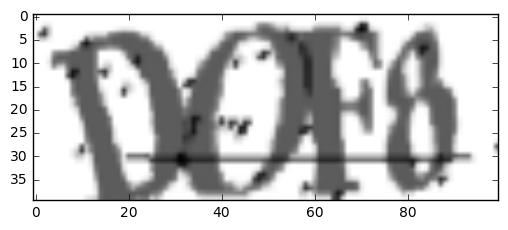

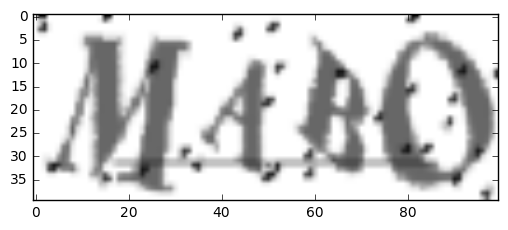

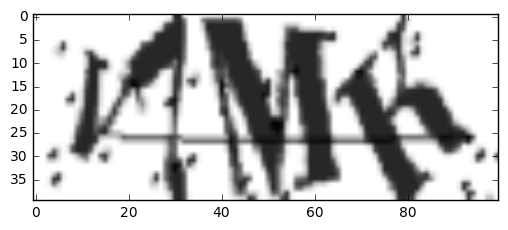

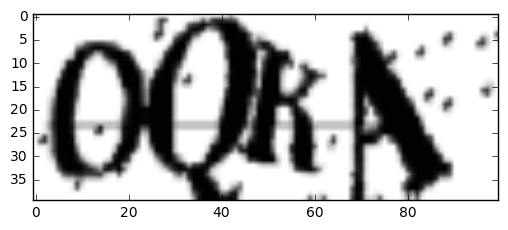

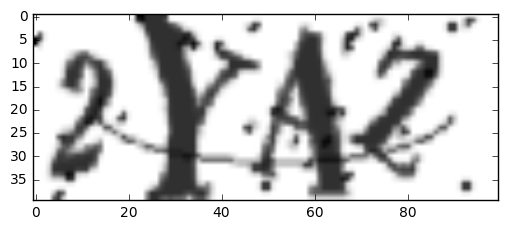

In [9]:
# with tf.Session(config=config) as sess:
# saver = tf.train.Saver()
# config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allow_growth = True
# sess = tf.InteractiveSession(config=config)
# sess.run(tf.global_variables_initializer())
# saver.restore(sess, "./model/model.ckpt")
# X, y = X_batch, y_batch
# print(accuracy.eval(feed_dict={x: X, y_: y, keep_prob: 1.0}))
pred = max_idx_p.eval(feed_dict={x: X, keep_prob: 1.0})
idx_lst = range(30,35)
for idx in idx_lst:
    print([char_map[_i] for _i in pred[idx]] )
    plt.figure()
    plt.imshow(X[idx].reshape((40, 100)), cmap='gray')

In [26]:
Y = np.argmax(y_batch[30, :, :], axis=1)
print([char_map[_i] for _i in Y ])


['6', '3', 'B', 'I']


In [8]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "./model/model.ckpt")

In [5]:
# Creates a graph.

a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [5]:
import pickle

with open('captcha.pickle', 'wb') as f:
    pickle.dump(X_train, f)
    pickle.dump(y_train, f)

In [39]:
sess.run(tf.global_variables_initializer())

In [14]:
with open('captcha.pickle', 'rb') as f:
    x, y = pickle.loads(f)

TypeError: a bytes-like object is required, not '_io.BufferedReader'

In [19]:
sess.run(tf.global_variables_initializer())

In [12]:
os.mkdir

(10000, 144)

ValueError: peek of closed file